# Fine-tune SAM on customized datasets (2D example)
1. Prepare original 2D images `data/MedSAMDemo_2D/` (Download link:https://drive.google.com/file/d/18GhVEODbTi17jSeBXdeLQ7vHPdtlTYXK/view?usp=share_link) 
2. Run `pre_grey_rgb2D.py` for pre-processing. Expected output: `./data/demo2D_vit_b/demo2d.npz`
3. Start this fine-tuning tutorial

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import monai
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from utils.SurfaceDice import compute_dice_coefficient
# set seeds
torch.manual_seed(2023)
np.random.seed(2023)

In [4]:
#%% create a dataset class to load npz data and return back image embeddings and ground truth
class NpzDataset(Dataset): 
    def __init__(self, data_root):
        self.data_root = data_root
        self.npz_files = sorted(os.listdir(self.data_root)) 
        self.npz_data = [np.load(join(data_root, f)) for f in self.npz_files]
        # this implementation is ugly but it works (and is also fast for feeding data to GPU) if your server has enough RAM
        # as an alternative, you can also use a list of npy files and load them one by one
        self.ori_gts = np.vstack([d['gts'] for d in self.npz_data])
        self.img_embeddings = np.vstack([d['img_embeddings'] for d in self.npz_data])
        print(f"{self.img_embeddings.shape=}, {self.ori_gts.shape=}")
    
    def __len__(self):
        return self.ori_gts.shape[0]

    def __getitem__(self, index):
        img_embed = self.img_embeddings[index]
        gt2D = self.ori_gts[index]
        y_indices, x_indices = np.where(gt2D > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = gt2D.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bboxes = np.array([x_min, y_min, x_max, y_max])
        # convert img embedding, mask, bounding box to torch tensor
        return torch.tensor(img_embed).float(), torch.tensor(gt2D[None, :,:]).long(), torch.tensor(bboxes).float()

In [5]:
# %% test dataset class and dataloader
npz_tr_path = 'data/demo2D_vit_b'
demo_dataset = NpzDataset(npz_tr_path)
demo_dataloader = DataLoader(demo_dataset, batch_size=1, shuffle=True)
for img_embed, gt2D, bboxes in demo_dataloader:
    # img_embed: (B, 256, 64, 64), gt2D: (B, 1, 256, 256), bboxes: (B, 4)
    print(f"{img_embed.shape=}, {gt2D.shape=}, {bboxes.shape=}")
    break

self.img_embeddings.shape=(82, 256, 64, 64), self.ori_gts.shape=(82, 256, 256)
img_embed.shape=torch.Size([1, 256, 64, 64]), gt2D.shape=torch.Size([1, 1, 256, 256]), bboxes.shape=torch.Size([1, 4])


In [6]:
# %% set up model for fine-tuning 
# train data path
npz_tr_path = 'data/demo2D_vit_b'
work_dir = './work_dir'
task_name = 'demo2D'
# prepare SAM model
model_type = 'vit_b'
checkpoint = 'work_dir/SAM/sam_vit_b_01ec64.pth'
device = 'cuda:0'
model_save_path = join(work_dir, task_name)
os.makedirs(model_save_path, exist_ok=True)
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
sam_model.train()
# Set up the optimizer, hyperparameter tuning will improve performance here
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [8]:
#%% train
num_epochs = 500
losses = []
best_loss = 1e10
train_dataset = NpzDataset(npz_tr_path)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
for epoch in range(num_epochs):
    epoch_loss = 0
    # train
    for step, (image_embedding, gt2D, boxes) in enumerate(tqdm(train_dataloader)):
        # do not compute gradients for image encoder and prompt encoder
        with torch.no_grad():
            # convert box to 1024x1024 grid
            box_np = boxes.numpy()
            sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
            box = sam_trans.apply_boxes(box_np, (gt2D.shape[-2], gt2D.shape[-1]))
            box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
            if len(box_torch.shape) == 2:
                box_torch = box_torch[:, None, :] # (B, 1, 4)
            # get prompt embeddings 
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )
        # predicted masks
        mask_predictions, _ = sam_model.mask_decoder(
            image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
            image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
          )

        loss = seg_loss(mask_predictions, gt2D.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= (step+1)
    losses.append(epoch_loss)
    print(f'EPOCH: {epoch}, Loss: {epoch_loss}')
    # save the latest model checkpoint
    torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_latest.pth'))
    # save the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_best.pth'))

self.img_embeddings.shape=(82, 256, 64, 64), self.ori_gts.shape=(82, 256, 256)


100%|██████████| 82/82 [00:02<00:00, 37.45it/s]


EPOCH: 0, Loss: 0.03692820958974885


100%|██████████| 82/82 [00:02<00:00, 39.21it/s]


EPOCH: 1, Loss: 0.036117451220023924


100%|██████████| 82/82 [00:02<00:00, 40.01it/s]


EPOCH: 2, Loss: 0.03651033741671864


100%|██████████| 82/82 [00:01<00:00, 41.64it/s]


EPOCH: 3, Loss: 0.036381846520958876


100%|██████████| 82/82 [00:01<00:00, 46.22it/s]


EPOCH: 4, Loss: 0.03685532401247722


100%|██████████| 82/82 [00:01<00:00, 46.96it/s]


EPOCH: 5, Loss: 0.03607158689964109


100%|██████████| 82/82 [00:02<00:00, 39.16it/s]


EPOCH: 6, Loss: 0.035406347455047976


100%|██████████| 82/82 [00:01<00:00, 42.69it/s]


EPOCH: 7, Loss: 0.036149493077906165


100%|██████████| 82/82 [00:01<00:00, 45.91it/s]


EPOCH: 8, Loss: 0.03569441961079109


100%|██████████| 82/82 [00:02<00:00, 39.48it/s]


EPOCH: 9, Loss: 0.03545465920029617


100%|██████████| 82/82 [00:01<00:00, 41.45it/s]


EPOCH: 10, Loss: 0.03537492853839223


100%|██████████| 82/82 [00:02<00:00, 39.90it/s]


EPOCH: 11, Loss: 0.035748651841791663


100%|██████████| 82/82 [00:01<00:00, 41.18it/s]


EPOCH: 12, Loss: 0.03487679580362832


100%|██████████| 82/82 [00:01<00:00, 41.78it/s]


EPOCH: 13, Loss: 0.03588199906232881


100%|██████████| 82/82 [00:02<00:00, 39.55it/s]


EPOCH: 14, Loss: 0.03606610254543584


100%|██████████| 82/82 [00:02<00:00, 40.10it/s]


EPOCH: 15, Loss: 0.037646188968565406


100%|██████████| 82/82 [00:01<00:00, 45.84it/s]


EPOCH: 16, Loss: 0.037893701617310684


100%|██████████| 82/82 [00:02<00:00, 40.18it/s]


EPOCH: 17, Loss: 0.03770211775128434


100%|██████████| 82/82 [00:02<00:00, 39.43it/s]


EPOCH: 18, Loss: 0.03927092653949086


100%|██████████| 82/82 [00:01<00:00, 41.66it/s]


EPOCH: 19, Loss: 0.04147776089063505


100%|██████████| 82/82 [00:01<00:00, 44.54it/s]


EPOCH: 20, Loss: 0.03693078494653469


100%|██████████| 82/82 [00:01<00:00, 44.97it/s]


EPOCH: 21, Loss: 0.03641665926793727


100%|██████████| 82/82 [00:02<00:00, 38.89it/s]


EPOCH: 22, Loss: 0.03505295296994651


100%|██████████| 82/82 [00:02<00:00, 39.16it/s]


EPOCH: 23, Loss: 0.03544573885638539


100%|██████████| 82/82 [00:01<00:00, 41.94it/s]


EPOCH: 24, Loss: 0.03474179128321206


100%|██████████| 82/82 [00:02<00:00, 39.80it/s]


EPOCH: 25, Loss: 0.03435243193696185


100%|██████████| 82/82 [00:01<00:00, 41.88it/s]


EPOCH: 26, Loss: 0.03560239876188883


100%|██████████| 82/82 [00:02<00:00, 39.83it/s]


EPOCH: 27, Loss: 0.034731659220486155


100%|██████████| 82/82 [00:02<00:00, 37.14it/s]


EPOCH: 28, Loss: 0.035243435603816334


100%|██████████| 82/82 [00:02<00:00, 39.15it/s]


EPOCH: 29, Loss: 0.03406891299457085


100%|██████████| 82/82 [00:01<00:00, 42.77it/s]


EPOCH: 30, Loss: 0.0340273380279541


100%|██████████| 82/82 [00:02<00:00, 39.07it/s]


EPOCH: 31, Loss: 0.03315353320866096


100%|██████████| 82/82 [00:02<00:00, 38.67it/s]


EPOCH: 32, Loss: 0.03408959871385156


100%|██████████| 82/82 [00:02<00:00, 38.58it/s]


EPOCH: 33, Loss: 0.03320833895264602


100%|██████████| 82/82 [00:02<00:00, 38.81it/s]


EPOCH: 34, Loss: 0.03293748599726979


100%|██████████| 82/82 [00:02<00:00, 39.96it/s]


EPOCH: 35, Loss: 0.03297141775852296


100%|██████████| 82/82 [00:02<00:00, 38.99it/s]


EPOCH: 36, Loss: 0.03446261766480237


100%|██████████| 82/82 [00:02<00:00, 39.08it/s]


EPOCH: 37, Loss: 0.03409332618480775


100%|██████████| 82/82 [00:02<00:00, 39.10it/s]


EPOCH: 38, Loss: 0.033648705337105726


100%|██████████| 82/82 [00:02<00:00, 37.18it/s]


EPOCH: 39, Loss: 0.03332577827500134


100%|██████████| 82/82 [00:02<00:00, 39.73it/s]


EPOCH: 40, Loss: 0.03360906388701462


100%|██████████| 82/82 [00:02<00:00, 38.28it/s]


EPOCH: 41, Loss: 0.033045676423282155


100%|██████████| 82/82 [00:02<00:00, 40.79it/s]


EPOCH: 42, Loss: 0.0331147378537713


100%|██████████| 82/82 [00:01<00:00, 42.63it/s]


EPOCH: 43, Loss: 0.03209835218220222


100%|██████████| 82/82 [00:02<00:00, 40.57it/s]


EPOCH: 44, Loss: 0.03239821442743627


100%|██████████| 82/82 [00:01<00:00, 46.22it/s]


EPOCH: 45, Loss: 0.03332739341549757


100%|██████████| 82/82 [00:01<00:00, 42.94it/s]


EPOCH: 46, Loss: 0.033004470714708654


100%|██████████| 82/82 [00:02<00:00, 39.11it/s]


EPOCH: 47, Loss: 0.032562571327860765


100%|██████████| 82/82 [00:01<00:00, 41.21it/s]


EPOCH: 48, Loss: 0.032439979111276024


100%|██████████| 82/82 [00:01<00:00, 42.78it/s]


EPOCH: 49, Loss: 0.03200594026867936


100%|██████████| 82/82 [00:01<00:00, 43.79it/s]


EPOCH: 50, Loss: 0.03256106376647949


100%|██████████| 82/82 [00:02<00:00, 36.62it/s]


EPOCH: 51, Loss: 0.03336445369371554


100%|██████████| 82/82 [00:01<00:00, 42.34it/s]


EPOCH: 52, Loss: 0.03387365980846126


100%|██████████| 82/82 [00:02<00:00, 40.67it/s]


EPOCH: 53, Loss: 0.03307052138375073


100%|██████████| 82/82 [00:01<00:00, 41.54it/s]


EPOCH: 54, Loss: 0.033118040823354955


100%|██████████| 82/82 [00:02<00:00, 39.00it/s]


EPOCH: 55, Loss: 0.033990409316086184


100%|██████████| 82/82 [00:02<00:00, 35.54it/s]


EPOCH: 56, Loss: 0.03299751078210226


100%|██████████| 82/82 [00:02<00:00, 39.71it/s]


EPOCH: 57, Loss: 0.03279173519553208


100%|██████████| 82/82 [00:01<00:00, 42.42it/s]


EPOCH: 58, Loss: 0.032150474263400564


100%|██████████| 82/82 [00:02<00:00, 40.76it/s]


EPOCH: 59, Loss: 0.032022175265521535


100%|██████████| 82/82 [00:01<00:00, 43.10it/s]


EPOCH: 60, Loss: 0.03138837581727563


100%|██████████| 82/82 [00:01<00:00, 42.60it/s]


EPOCH: 61, Loss: 0.03241301527837428


100%|██████████| 82/82 [00:02<00:00, 37.09it/s]


EPOCH: 62, Loss: 0.032476979784849216


100%|██████████| 82/82 [00:02<00:00, 38.41it/s]


EPOCH: 63, Loss: 0.03164278297889524


100%|██████████| 82/82 [00:02<00:00, 40.60it/s]


EPOCH: 64, Loss: 0.03127746174975139


100%|██████████| 82/82 [00:02<00:00, 37.90it/s]


EPOCH: 65, Loss: 0.03217543479872913


100%|██████████| 82/82 [00:01<00:00, 43.29it/s]


EPOCH: 66, Loss: 0.0318978537873524


100%|██████████| 82/82 [00:02<00:00, 39.97it/s]


EPOCH: 67, Loss: 0.03264899006704005


100%|██████████| 82/82 [00:02<00:00, 38.51it/s]


EPOCH: 68, Loss: 0.0331158434472433


100%|██████████| 82/82 [00:01<00:00, 43.24it/s]


EPOCH: 69, Loss: 0.03220501324025596


100%|██████████| 82/82 [00:02<00:00, 39.33it/s]


EPOCH: 70, Loss: 0.030744479196827587


100%|██████████| 82/82 [00:01<00:00, 42.06it/s]


EPOCH: 71, Loss: 0.03141350862456531


100%|██████████| 82/82 [00:02<00:00, 39.38it/s]


EPOCH: 72, Loss: 0.0312647274354609


100%|██████████| 82/82 [00:02<00:00, 40.58it/s]


EPOCH: 73, Loss: 0.03106142108033343


100%|██████████| 82/82 [00:01<00:00, 41.67it/s]


EPOCH: 74, Loss: 0.03344165770018973


100%|██████████| 82/82 [00:02<00:00, 38.85it/s]


EPOCH: 75, Loss: 0.034020069168835154


100%|██████████| 82/82 [00:02<00:00, 38.42it/s]


EPOCH: 76, Loss: 0.032659694915864526


100%|██████████| 82/82 [00:02<00:00, 38.05it/s]


EPOCH: 77, Loss: 0.03292255576063947


100%|██████████| 82/82 [00:02<00:00, 40.45it/s]


EPOCH: 78, Loss: 0.03162925999339034


100%|██████████| 82/82 [00:02<00:00, 39.45it/s]


EPOCH: 79, Loss: 0.03015187746141015


100%|██████████| 82/82 [00:02<00:00, 39.74it/s]


EPOCH: 80, Loss: 0.030316964882176098


100%|██████████| 82/82 [00:01<00:00, 44.24it/s]


EPOCH: 81, Loss: 0.029875037146777642


100%|██████████| 82/82 [00:02<00:00, 40.42it/s]


EPOCH: 82, Loss: 0.030023305154428248


100%|██████████| 82/82 [00:02<00:00, 39.84it/s]


EPOCH: 83, Loss: 0.031016237852050037


100%|██████████| 82/82 [00:01<00:00, 43.48it/s]


EPOCH: 84, Loss: 0.030601047161148816


100%|██████████| 82/82 [00:01<00:00, 46.72it/s]


EPOCH: 85, Loss: 0.031508537327370995


100%|██████████| 82/82 [00:01<00:00, 46.79it/s]


EPOCH: 86, Loss: 0.03169593651120255


100%|██████████| 82/82 [00:02<00:00, 39.61it/s]


EPOCH: 87, Loss: 0.03013317759444074


100%|██████████| 82/82 [00:02<00:00, 40.15it/s]


EPOCH: 88, Loss: 0.031760172873008544


100%|██████████| 82/82 [00:02<00:00, 39.58it/s]


EPOCH: 89, Loss: 0.030996130007069286


100%|██████████| 82/82 [00:02<00:00, 38.60it/s]


EPOCH: 90, Loss: 0.03103810258027984


100%|██████████| 82/82 [00:02<00:00, 39.96it/s]


EPOCH: 91, Loss: 0.0319809855484381


100%|██████████| 82/82 [00:02<00:00, 39.16it/s]


EPOCH: 92, Loss: 0.03022257874651653


100%|██████████| 82/82 [00:02<00:00, 39.32it/s]


EPOCH: 93, Loss: 0.03022607579463866


100%|██████████| 82/82 [00:02<00:00, 39.39it/s]


EPOCH: 94, Loss: 0.03057581695114694


100%|██████████| 82/82 [00:01<00:00, 42.00it/s]


EPOCH: 95, Loss: 0.029791368943888966


100%|██████████| 82/82 [00:02<00:00, 40.25it/s]


EPOCH: 96, Loss: 0.028768881065089527


100%|██████████| 82/82 [00:02<00:00, 39.00it/s]


EPOCH: 97, Loss: 0.029472556056045904


100%|██████████| 82/82 [00:02<00:00, 39.96it/s]


EPOCH: 98, Loss: 0.029214295672207343


100%|██████████| 82/82 [00:02<00:00, 40.08it/s]


EPOCH: 99, Loss: 0.029547423124313354


100%|██████████| 82/82 [00:02<00:00, 38.80it/s]


EPOCH: 100, Loss: 0.029413354832951617


100%|██████████| 82/82 [00:02<00:00, 39.37it/s]


EPOCH: 101, Loss: 0.02940041480994806


100%|██████████| 82/82 [00:01<00:00, 45.82it/s]


EPOCH: 102, Loss: 0.02871840610736754


100%|██████████| 82/82 [00:01<00:00, 46.36it/s]


EPOCH: 103, Loss: 0.028816082128664343


100%|██████████| 82/82 [00:02<00:00, 38.97it/s]


EPOCH: 104, Loss: 0.028839601976115528


100%|██████████| 82/82 [00:02<00:00, 40.82it/s]


EPOCH: 105, Loss: 0.030591170962263898


100%|██████████| 82/82 [00:01<00:00, 47.84it/s]


EPOCH: 106, Loss: 0.030020436135734


100%|██████████| 82/82 [00:02<00:00, 39.30it/s]


EPOCH: 107, Loss: 0.0300771935683925


100%|██████████| 82/82 [00:02<00:00, 39.98it/s]


EPOCH: 108, Loss: 0.03131815863818657


100%|██████████| 82/82 [00:01<00:00, 41.92it/s]


EPOCH: 109, Loss: 0.03206078017630228


100%|██████████| 82/82 [00:02<00:00, 39.80it/s]


EPOCH: 110, Loss: 0.0298801922216648


100%|██████████| 82/82 [00:02<00:00, 38.62it/s]


EPOCH: 111, Loss: 0.029966173375525127


100%|██████████| 82/82 [00:01<00:00, 43.05it/s]


EPOCH: 112, Loss: 0.028387209991129432


100%|██████████| 82/82 [00:01<00:00, 45.46it/s]


EPOCH: 113, Loss: 0.028924242025468408


100%|██████████| 82/82 [00:02<00:00, 40.78it/s]


EPOCH: 114, Loss: 0.028493438552065594


100%|██████████| 82/82 [00:02<00:00, 39.85it/s]


EPOCH: 115, Loss: 0.029084067519118146


100%|██████████| 82/82 [00:02<00:00, 39.98it/s]


EPOCH: 116, Loss: 0.027869167124352803


100%|██████████| 82/82 [00:02<00:00, 38.63it/s]


EPOCH: 117, Loss: 0.027753891741357197


100%|██████████| 82/82 [00:01<00:00, 41.40it/s]


EPOCH: 118, Loss: 0.028757034278497462


100%|██████████| 82/82 [00:02<00:00, 38.47it/s]


EPOCH: 119, Loss: 0.02800958985235633


100%|██████████| 82/82 [00:01<00:00, 41.02it/s]


EPOCH: 120, Loss: 0.028312930246678795


100%|██████████| 82/82 [00:02<00:00, 39.61it/s]


EPOCH: 121, Loss: 0.03007754756183159


100%|██████████| 82/82 [00:01<00:00, 42.07it/s]


EPOCH: 122, Loss: 0.03023036950972022


100%|██████████| 82/82 [00:01<00:00, 41.56it/s]


EPOCH: 123, Loss: 0.02830782241937591


100%|██████████| 82/82 [00:01<00:00, 41.69it/s]


EPOCH: 124, Loss: 0.02801738424998958


100%|██████████| 82/82 [00:02<00:00, 39.80it/s]


EPOCH: 125, Loss: 0.0288504652860688


100%|██████████| 82/82 [00:02<00:00, 39.93it/s]


EPOCH: 126, Loss: 0.02917626718195473


100%|██████████| 82/82 [00:02<00:00, 38.65it/s]


EPOCH: 127, Loss: 0.0282951847809117


100%|██████████| 82/82 [00:01<00:00, 44.42it/s]


EPOCH: 128, Loss: 0.027935555068458


100%|██████████| 82/82 [00:02<00:00, 40.22it/s]


EPOCH: 129, Loss: 0.027910648322686915


100%|██████████| 82/82 [00:02<00:00, 40.11it/s]


EPOCH: 130, Loss: 0.028346594513916388


100%|██████████| 82/82 [00:02<00:00, 38.88it/s]


EPOCH: 131, Loss: 0.028343326434856507


100%|██████████| 82/82 [00:02<00:00, 39.83it/s]


EPOCH: 132, Loss: 0.02777269555301201


100%|██████████| 82/82 [00:01<00:00, 45.72it/s]


EPOCH: 133, Loss: 0.027633770209986988


100%|██████████| 82/82 [00:01<00:00, 45.01it/s]


EPOCH: 134, Loss: 0.029960274696350098


100%|██████████| 82/82 [00:02<00:00, 38.86it/s]


EPOCH: 135, Loss: 0.028665406674873536


100%|██████████| 82/82 [00:01<00:00, 41.51it/s]


EPOCH: 136, Loss: 0.027603672771919066


100%|██████████| 82/82 [00:02<00:00, 40.97it/s]


EPOCH: 137, Loss: 0.02744659854144585


100%|██████████| 82/82 [00:02<00:00, 39.93it/s]


EPOCH: 138, Loss: 0.027162668181628716


100%|██████████| 82/82 [00:01<00:00, 43.93it/s]


EPOCH: 139, Loss: 0.02715093987744029


100%|██████████| 82/82 [00:02<00:00, 39.65it/s]


EPOCH: 140, Loss: 0.027449532252986256


100%|██████████| 82/82 [00:01<00:00, 41.79it/s]


EPOCH: 141, Loss: 0.026627381400364202


100%|██████████| 82/82 [00:02<00:00, 39.77it/s]


EPOCH: 142, Loss: 0.028914280054045886


100%|██████████| 82/82 [00:02<00:00, 37.36it/s]


EPOCH: 143, Loss: 0.028313069808773877


100%|██████████| 82/82 [00:01<00:00, 41.98it/s]


EPOCH: 144, Loss: 0.026918860470376362


100%|██████████| 82/82 [00:02<00:00, 40.96it/s]


EPOCH: 145, Loss: 0.0267936514645088


100%|██████████| 82/82 [00:02<00:00, 40.28it/s]


EPOCH: 146, Loss: 0.026735653964484612


100%|██████████| 82/82 [00:02<00:00, 39.00it/s]


EPOCH: 147, Loss: 0.02679152677698833


100%|██████████| 82/82 [00:02<00:00, 40.23it/s]


EPOCH: 148, Loss: 0.026774171648955927


100%|██████████| 82/82 [00:02<00:00, 39.93it/s]


EPOCH: 149, Loss: 0.027512058252241553


100%|██████████| 82/82 [00:02<00:00, 39.56it/s]


EPOCH: 150, Loss: 0.02640816569328308


100%|██████████| 82/82 [00:01<00:00, 44.57it/s]


EPOCH: 151, Loss: 0.02576139641971123


100%|██████████| 82/82 [00:02<00:00, 39.71it/s]


EPOCH: 152, Loss: 0.030970720983133082


100%|██████████| 82/82 [00:01<00:00, 41.51it/s]


EPOCH: 153, Loss: 0.030470073949999926


100%|██████████| 82/82 [00:01<00:00, 44.45it/s]


EPOCH: 154, Loss: 0.026837952980181067


100%|██████████| 82/82 [00:02<00:00, 40.77it/s]


EPOCH: 155, Loss: 0.027879021516660364


100%|██████████| 82/82 [00:02<00:00, 38.78it/s]


EPOCH: 156, Loss: 0.026305230652413716


100%|██████████| 82/82 [00:01<00:00, 42.22it/s]


EPOCH: 157, Loss: 0.026491308357657457


100%|██████████| 82/82 [00:02<00:00, 39.71it/s]


EPOCH: 158, Loss: 0.025725416293958338


100%|██████████| 82/82 [00:02<00:00, 40.59it/s]


EPOCH: 159, Loss: 0.026068715787515406


100%|██████████| 82/82 [00:02<00:00, 39.41it/s]


EPOCH: 160, Loss: 0.02607072271951815


100%|██████████| 82/82 [00:01<00:00, 44.08it/s]


EPOCH: 161, Loss: 0.026519611841294824


100%|██████████| 82/82 [00:02<00:00, 40.47it/s]


EPOCH: 162, Loss: 0.025675119423284765


100%|██████████| 82/82 [00:01<00:00, 41.88it/s]


EPOCH: 163, Loss: 0.02604619322753534


100%|██████████| 82/82 [00:02<00:00, 38.37it/s]


EPOCH: 164, Loss: 0.025687029448951165


100%|██████████| 82/82 [00:01<00:00, 46.91it/s]


EPOCH: 165, Loss: 0.02606581623961286


100%|██████████| 82/82 [00:01<00:00, 43.06it/s]


EPOCH: 166, Loss: 0.026326325608462823


100%|██████████| 82/82 [00:02<00:00, 40.96it/s]


EPOCH: 167, Loss: 0.026616119756931213


100%|██████████| 82/82 [00:01<00:00, 42.13it/s]


EPOCH: 168, Loss: 0.026108733037622962


100%|██████████| 82/82 [00:01<00:00, 44.41it/s]


EPOCH: 169, Loss: 0.027749214230514154


100%|██████████| 82/82 [00:01<00:00, 43.96it/s]


EPOCH: 170, Loss: 0.02672648284493423


100%|██████████| 82/82 [00:02<00:00, 39.19it/s]


EPOCH: 171, Loss: 0.02585712220610642


100%|██████████| 82/82 [00:02<00:00, 40.36it/s]


EPOCH: 172, Loss: 0.02652007414073479


100%|██████████| 82/82 [00:02<00:00, 37.87it/s]


EPOCH: 173, Loss: 0.025277050530038227


100%|██████████| 82/82 [00:01<00:00, 42.35it/s]


EPOCH: 174, Loss: 0.025110870599746704


100%|██████████| 82/82 [00:02<00:00, 39.37it/s]


EPOCH: 175, Loss: 0.024331548591939416


100%|██████████| 82/82 [00:02<00:00, 40.83it/s]


EPOCH: 176, Loss: 0.02503390065053614


100%|██████████| 82/82 [00:01<00:00, 41.06it/s]


EPOCH: 177, Loss: 0.024712247819435304


100%|██████████| 82/82 [00:02<00:00, 39.52it/s]


EPOCH: 178, Loss: 0.026037871110730054


100%|██████████| 82/82 [00:01<00:00, 44.42it/s]


EPOCH: 179, Loss: 0.026026270738462122


100%|██████████| 82/82 [00:01<00:00, 41.76it/s]


EPOCH: 180, Loss: 0.025272623067948877


100%|██████████| 82/82 [00:02<00:00, 38.94it/s]


EPOCH: 181, Loss: 0.025334197573545502


100%|██████████| 82/82 [00:01<00:00, 41.17it/s]


EPOCH: 182, Loss: 0.025375942631465632


100%|██████████| 82/82 [00:02<00:00, 39.85it/s]


EPOCH: 183, Loss: 0.02591668105706936


100%|██████████| 82/82 [00:02<00:00, 38.94it/s]


EPOCH: 184, Loss: 0.026042785586380377


100%|██████████| 82/82 [00:02<00:00, 39.75it/s]


EPOCH: 185, Loss: 0.025498600994668354


100%|██████████| 82/82 [00:02<00:00, 38.92it/s]


EPOCH: 186, Loss: 0.024777886344165338


100%|██████████| 82/82 [00:01<00:00, 41.71it/s]


EPOCH: 187, Loss: 0.025064079499826197


100%|██████████| 82/82 [00:02<00:00, 39.47it/s]


EPOCH: 188, Loss: 0.02487903251880553


100%|██████████| 82/82 [00:02<00:00, 38.26it/s]


EPOCH: 189, Loss: 0.0251505236800124


100%|██████████| 82/82 [00:02<00:00, 37.34it/s]


EPOCH: 190, Loss: 0.025612683557882543


100%|██████████| 82/82 [00:02<00:00, 38.87it/s]


EPOCH: 191, Loss: 0.02497101193521081


100%|██████████| 82/82 [00:02<00:00, 39.47it/s]


EPOCH: 192, Loss: 0.024485348201379542


100%|██████████| 82/82 [00:01<00:00, 46.06it/s]


EPOCH: 193, Loss: 0.024596606085940106


100%|██████████| 82/82 [00:02<00:00, 40.59it/s]


EPOCH: 194, Loss: 0.024754591104460925


100%|██████████| 82/82 [00:01<00:00, 42.63it/s]


EPOCH: 195, Loss: 0.02510307038702616


100%|██████████| 82/82 [00:01<00:00, 41.53it/s]


EPOCH: 196, Loss: 0.026615104297312293


100%|██████████| 82/82 [00:01<00:00, 45.13it/s]


EPOCH: 197, Loss: 0.024895085067283815


100%|██████████| 82/82 [00:02<00:00, 39.90it/s]


EPOCH: 198, Loss: 0.025553640069031134


100%|██████████| 82/82 [00:01<00:00, 43.40it/s]


EPOCH: 199, Loss: 0.025509065971141907


100%|██████████| 82/82 [00:02<00:00, 38.57it/s]


EPOCH: 200, Loss: 0.02628596090688938


100%|██████████| 82/82 [00:02<00:00, 39.91it/s]


EPOCH: 201, Loss: 0.026141322240596863


100%|██████████| 82/82 [00:01<00:00, 41.67it/s]


EPOCH: 202, Loss: 0.025020822519209326


100%|██████████| 82/82 [00:01<00:00, 41.58it/s]


EPOCH: 203, Loss: 0.024296259734688734


100%|██████████| 82/82 [00:02<00:00, 36.72it/s]


EPOCH: 204, Loss: 0.02412974689064956


100%|██████████| 82/82 [00:02<00:00, 39.75it/s]


EPOCH: 205, Loss: 0.023890424065473603


100%|██████████| 82/82 [00:02<00:00, 39.40it/s]


EPOCH: 206, Loss: 0.024635425428064857


100%|██████████| 82/82 [00:02<00:00, 38.98it/s]


EPOCH: 207, Loss: 0.024162123116051277


100%|██████████| 82/82 [00:01<00:00, 42.86it/s]


EPOCH: 208, Loss: 0.0238956118502268


100%|██████████| 82/82 [00:02<00:00, 40.13it/s]


EPOCH: 209, Loss: 0.024178393003417224


100%|██████████| 82/82 [00:02<00:00, 38.50it/s]


EPOCH: 210, Loss: 0.024229929941456493


100%|██████████| 82/82 [00:01<00:00, 44.22it/s]


EPOCH: 211, Loss: 0.02478541397466892


100%|██████████| 82/82 [00:01<00:00, 45.93it/s]


EPOCH: 212, Loss: 0.02457330648492022


100%|██████████| 82/82 [00:02<00:00, 40.39it/s]


EPOCH: 213, Loss: 0.023760529553017964


100%|██████████| 82/82 [00:02<00:00, 40.48it/s]


EPOCH: 214, Loss: 0.022867789355719963


100%|██████████| 82/82 [00:01<00:00, 41.58it/s]


EPOCH: 215, Loss: 0.02416478569914655


100%|██████████| 82/82 [00:02<00:00, 39.49it/s]


EPOCH: 216, Loss: 0.02553357438343327


100%|██████████| 82/82 [00:02<00:00, 39.99it/s]


EPOCH: 217, Loss: 0.024607880813319508


100%|██████████| 82/82 [00:01<00:00, 42.66it/s]


EPOCH: 218, Loss: 0.024321891185713977


100%|██████████| 82/82 [00:02<00:00, 39.91it/s]


EPOCH: 219, Loss: 0.02452901005744934


100%|██████████| 82/82 [00:02<00:00, 37.85it/s]


EPOCH: 220, Loss: 0.023982818533734577


100%|██████████| 82/82 [00:01<00:00, 42.02it/s]


EPOCH: 221, Loss: 0.02377822631742896


100%|██████████| 82/82 [00:02<00:00, 39.22it/s]


EPOCH: 222, Loss: 0.02364539518588927


100%|██████████| 82/82 [00:02<00:00, 39.97it/s]


EPOCH: 223, Loss: 0.022526118086605536


100%|██████████| 82/82 [00:02<00:00, 39.93it/s]


EPOCH: 224, Loss: 0.022324336011235308


100%|██████████| 82/82 [00:02<00:00, 39.61it/s]


EPOCH: 225, Loss: 0.02219500192781774


100%|██████████| 82/82 [00:02<00:00, 38.15it/s]


EPOCH: 226, Loss: 0.02255345771952373


100%|██████████| 82/82 [00:02<00:00, 38.62it/s]


EPOCH: 227, Loss: 0.023130339093324615


100%|██████████| 82/82 [00:01<00:00, 45.97it/s]


EPOCH: 228, Loss: 0.02321865573161986


100%|██████████| 82/82 [00:01<00:00, 46.11it/s]


EPOCH: 229, Loss: 0.02398239403236203


100%|██████████| 82/82 [00:01<00:00, 41.29it/s]


EPOCH: 230, Loss: 0.02314241194143528


100%|██████████| 82/82 [00:02<00:00, 40.56it/s]


EPOCH: 231, Loss: 0.022541845717081208


100%|██████████| 82/82 [00:02<00:00, 39.24it/s]


EPOCH: 232, Loss: 0.023338413093148207


100%|██████████| 82/82 [00:02<00:00, 40.51it/s]


EPOCH: 233, Loss: 0.02279268459575932


100%|██████████| 82/82 [00:02<00:00, 38.71it/s]


EPOCH: 234, Loss: 0.02327477859287727


100%|██████████| 82/82 [00:02<00:00, 39.86it/s]


EPOCH: 235, Loss: 0.022842824459075928


100%|██████████| 82/82 [00:02<00:00, 39.09it/s]


EPOCH: 236, Loss: 0.023710057502839624


100%|██████████| 82/82 [00:01<00:00, 47.61it/s]


EPOCH: 237, Loss: 0.023237373770737067


100%|██████████| 82/82 [00:01<00:00, 45.87it/s]


EPOCH: 238, Loss: 0.02391438949398878


100%|██████████| 82/82 [00:02<00:00, 40.29it/s]


EPOCH: 239, Loss: 0.02350595666141045


100%|██████████| 82/82 [00:01<00:00, 42.95it/s]


EPOCH: 240, Loss: 0.022285950619999956


100%|██████████| 82/82 [00:01<00:00, 41.66it/s]


EPOCH: 241, Loss: 0.022583667824908


100%|██████████| 82/82 [00:02<00:00, 39.27it/s]


EPOCH: 242, Loss: 0.022637435575810876


100%|██████████| 82/82 [00:02<00:00, 39.62it/s]


EPOCH: 243, Loss: 0.022761274401734515


100%|██████████| 82/82 [00:02<00:00, 39.79it/s]


EPOCH: 244, Loss: 0.022690427739445757


100%|██████████| 82/82 [00:01<00:00, 44.19it/s]


EPOCH: 245, Loss: 0.022828311454959033


100%|██████████| 82/82 [00:01<00:00, 41.58it/s]


EPOCH: 246, Loss: 0.023708158149951843


100%|██████████| 82/82 [00:02<00:00, 38.82it/s]


EPOCH: 247, Loss: 0.024734484713251997


100%|██████████| 82/82 [00:02<00:00, 38.60it/s]


EPOCH: 248, Loss: 0.023682489627745093


100%|██████████| 82/82 [00:02<00:00, 40.85it/s]


EPOCH: 249, Loss: 0.023624231902564446


100%|██████████| 82/82 [00:02<00:00, 38.01it/s]


EPOCH: 250, Loss: 0.022789389621920703


100%|██████████| 82/82 [00:01<00:00, 45.66it/s]


EPOCH: 251, Loss: 0.022999128190482537


100%|██████████| 82/82 [00:01<00:00, 41.18it/s]


EPOCH: 252, Loss: 0.023135161254464125


100%|██████████| 82/82 [00:02<00:00, 40.42it/s]


EPOCH: 253, Loss: 0.02344526023399539


100%|██████████| 82/82 [00:02<00:00, 40.22it/s]


EPOCH: 254, Loss: 0.02231283667610913


100%|██████████| 82/82 [00:01<00:00, 44.08it/s]


EPOCH: 255, Loss: 0.02142650397812448


100%|██████████| 82/82 [00:01<00:00, 42.13it/s]


EPOCH: 256, Loss: 0.02156837829729406


100%|██████████| 82/82 [00:01<00:00, 44.89it/s]


EPOCH: 257, Loss: 0.02236239575758213


100%|██████████| 82/82 [00:02<00:00, 39.42it/s]


EPOCH: 258, Loss: 0.022174790138151587


100%|██████████| 82/82 [00:01<00:00, 45.73it/s]


EPOCH: 259, Loss: 0.02155761166316707


100%|██████████| 82/82 [00:02<00:00, 40.59it/s]


EPOCH: 260, Loss: 0.021560677667943444


100%|██████████| 82/82 [00:02<00:00, 40.18it/s]


EPOCH: 261, Loss: 0.021079784486351942


100%|██████████| 82/82 [00:02<00:00, 38.30it/s]


EPOCH: 262, Loss: 0.02124292385287401


100%|██████████| 82/82 [00:02<00:00, 40.86it/s]


EPOCH: 263, Loss: 0.02128687791708039


 45%|████▌     | 37/82 [00:00<00:01, 38.31it/s]


KeyboardInterrupt: 

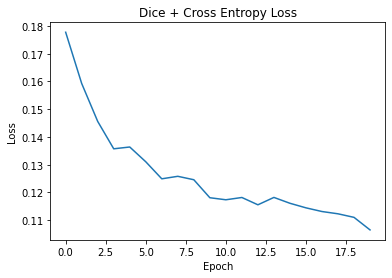

In [7]:
# plot loss
plt.plot(losses)
plt.title('Dice + Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show() # comment this line if you are running on a server
plt.savefig(join(model_save_path, 'train_loss.png'))
plt.close()

In [14]:
#%% compare the segmentation results between the original SAM model and the fine-tuned model
# load the original SAM model
from skimage import io
ori_sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
ori_sam_predictor = SamPredictor(ori_sam_model)

ts_img_path = 'data/MedSAMDemo_2D/test/images'
ts_gt_path = 'data/MedSAMDemo_2D/test/labels'
test_names = sorted(os.listdir(ts_img_path))

# random select a test case
img_idx = np.random.randint(len(test_names))
image_data = io.imread(join(ts_img_path, test_names[img_idx]))
if image_data.shape[-1]>3 and len(image_data.shape)==3:
    image_data = image_data[:,:,:3]
if len(image_data.shape)==2:
    image_data = np.repeat(image_data[:,:,None], 3, axis=-1)
# read ground truth (gt should have the same name as the image) and simulate a bounding box
def get_bbox_from_mask(mask):
    
    '''Returns a bounding box from a mask'''
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = mask.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))

    return np.array([x_min, y_min, x_max, y_max])

# gt_data = io.imread(join(ts_gt_path, test_names[img_idx]))
# bbox_raw = get_bbox_from_mask(gt_data)


# preprocess: cut-off and max-min normalization
lower_bound, upper_bound = np.percentile(image_data, 0.5), np.percentile(image_data, 99.5)
image_data_pre = np.clip(image_data, lower_bound, upper_bound)
image_data_pre = (image_data_pre - np.min(image_data_pre))/(np.max(image_data_pre)-np.min(image_data_pre))*255.0
image_data_pre[image_data==0] = 0
image_data_pre = np.uint8(image_data_pre)
H, W, _ = image_data_pre.shape

# predict the segmentation mask using the original SAM model
ori_sam_predictor.set_image(image_data_pre)
ori_sam_seg, _, _ = ori_sam_predictor.predict(point_coords=None, box=None, multimask_output=False)

In [15]:
# predict the segmentation mask using the fine-tuned model
# resize image to 3*1024*1024
sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
resize_img = sam_transform.apply_image(image_data_pre)
resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)
input_image = sam_model.preprocess(resize_img_tensor[None,:,:,:]) # (1, 3, 1024, 1024)
assert input_image.shape == (1, 3, sam_model.image_encoder.img_size, sam_model.image_encoder.img_size), 'input image should be resized to 1024*1024'

with torch.no_grad():
    # pre-compute the image embedding
    ts_img_embedding = sam_model.image_encoder(input_image)
    # convert box to 1024x1024 grid
    # bbox = sam_trans.apply_boxes(bbox_raw, (H, W))
    # print(f'{bbox_raw=} -> {bbox=}')
    # box_torch = torch.as_tensor(bbox, dtype=torch.float, device=device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 4) -> (B, 1, 4) #My code for not showing the bbox
    
    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    medsam_seg_prob, _ = sam_model.mask_decoder(
        image_embeddings=ts_img_embedding.to(device), # (B, 256, 64, 64)
        image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )
    medsam_seg_prob = torch.sigmoid(medsam_seg_prob)
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
    print(medsam_seg.shape)

(256, 256)


In [110]:
# ori_sam_dsc = compute_dice_coefficient(gt_data>0, ori_sam_seg>0)
# medsam_dsc = compute_dice_coefficient(gt_data>0, medsam_seg>0)
# print('Original SAM DSC: {:.4f}'.format(ori_sam_dsc), 'MedSAM DSC: {:.4f}'.format(medsam_dsc))

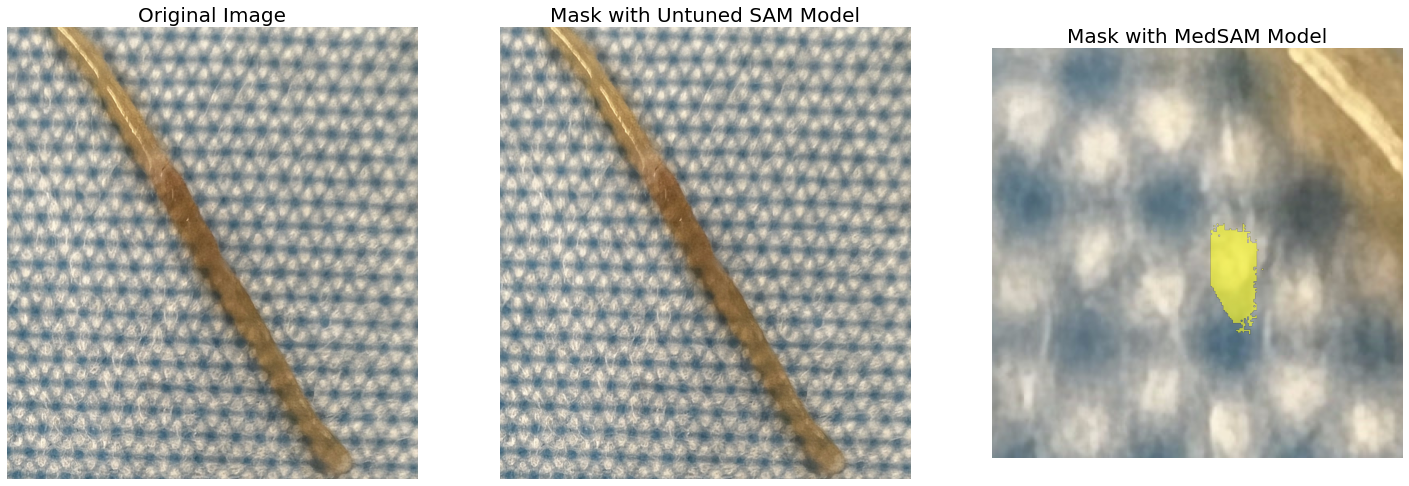

In [16]:
#%% visualize the segmentation results of the middle slice
# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))    


_, axs = plt.subplots(1, 3, figsize=(25, 25))
axs[0].imshow(image_data)
# show_mask(gt_data>0, axs[0])
# show_box(box_np[img_id], axs[0])
axs[0].set_title('Original Image', fontsize=20)
axs[0].axis('off')

axs[1].imshow(image_data)
show_mask(ori_sam_seg, axs[1])
# show_box(bbox_raw, axs[1])
# add text to image to show dice score
# axs[1].text(0.5, 0.5, 'SAM DSC: {:.4f}'.format(ori_sam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='blue')
axs[1].set_title('Mask with Untuned SAM Model', fontsize=20)
axs[1].axis('off')

axs[2].imshow(image_data)
show_mask(medsam_seg, axs[2])
# show_box(bbox_raw, axs[2])
# add text to image to show dice score
# axs[2].text(0.5, 0.5, 'MedSAM DSC: {:.4f}'.format(medsam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='blue')
axs[2].set_title('Mask with MedSAM Model', fontsize=20)
axs[2].axis('off')
plt.show()  
plt.subplots_adjust(wspace=0.01, hspace=0)
# save plot
# plt.savefig(join(model_save_path, test_npzs[npz_idx].split('.npz')[0] + str(img_id).zfill(3) + '.png'), bbox_inches='tight', dpi=300)
plt.close()